# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">An Simple Analysis for Statistic Class</center>

<p><center style="color:#949494; font-family: consolas; font-size: 20px;">Zhongguan(Ryan) Wen | December 9</center></p>

<font face='consolas' size=3 color=#f8000b>0. Import Packages</font>

In [1411]:
from astropy.utils.masked.function_helpers import median
from dask.array.random import normal
from matplotlib.lines import lineStyles
from numba.core.cgutils import if_zero
from scipy.signal.windows import tukey
%matplotlib inline

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
import scipy.stats as stats
from scipy.stats import boxcox  # Normal transform
from scipy.stats import levene  # Homogeneity of variance test

# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols  
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import  warnings
warnings.filterwarnings('ignore')

In [1412]:
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741', '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

<font face='consolas' size=3 color=#f8000b>1. Load Data</font>

In [1413]:
df_o = pd.read_csv('cardio_train.csv', sep=';', index_col=0)
df = df_o

print('The shape of the train data:', df.shape)
df.info()

The shape of the train data: (70000, 12)
<class 'pandas.core.frame.DataFrame'>
Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [1414]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [1415]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,70000.0,19468.865814,2467.251667,10798.0,17664.0,19703.0,21327.0,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.0,1.0,2.0,2.0
height,70000.0,164.359229,8.210126,55.0,159.0,165.0,170.0,250.0
weight,70000.0,74.205690,14.395757,10.0,65.0,72.0,82.0,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.0,120.0,140.0,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.0,80.0,90.0,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.0,1.0,2.0,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.0,1.0,1.0,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.0,0.0,0.0,1.0
alco,70000.0,0.053771,0.225568,0.0,0.0,0.0,0.0,1.0


<font face='consolas' size=3 color=#f8000b>2. Exploratory Data Analysis, EDA</font>

In [1416]:
# Divide variables into numerical and categorical variables
num_var = [column for column in df.columns if df[column].nunique() > 3]
cat_var = [column for column in df.columns if df[column].nunique() <= 3]

In [1417]:
# Replace
df.cholesterol.replace([1, 2, 3] ,["normal",  "above normal", "well above normal"], inplace=True)
df.gluc.replace([1, 2, 3] , ["normal", "above normal", "well above normal"], inplace=True)
df.smoke.replace([0, 1] , ["No", "Yes"] , inplace=True)
df.gender.replace([1, 2], ["Women", "Men"] , inplace=True)
df['alco'].replace({0:"No Drink", 1: "Drink"} , inplace=True )
df['active'].replace({0:'Inactive', 1:'Active'} , inplace=True )
df['cardio'].replace({0:'Absence', 1:'Presence'} , inplace=True )
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,Men,168,62.0,110,80,normal,normal,No,No Drink,Active,Absence
1,20228,Women,156,85.0,140,90,well above normal,normal,No,No Drink,Active,Presence
2,18857,Women,165,64.0,130,70,well above normal,normal,No,No Drink,Inactive,Presence
3,17623,Men,169,82.0,150,100,normal,normal,No,No Drink,Active,Presence
4,17474,Women,156,56.0,100,60,normal,normal,No,No Drink,Inactive,Absence


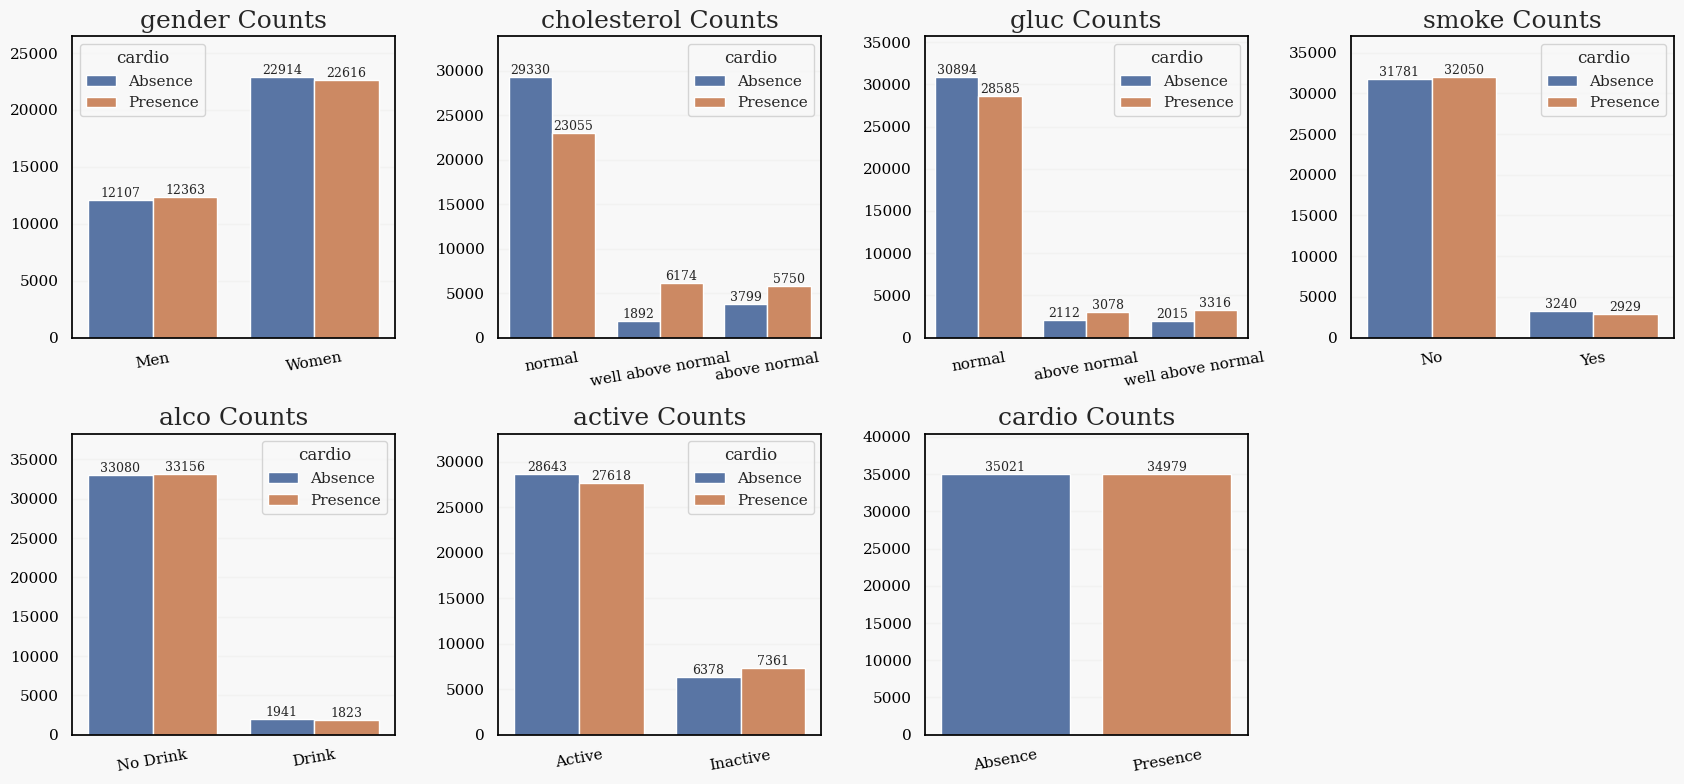

In [1418]:
def plot_count(df, columns, n_cols, hue):
    """
    # Function to genear countplot
    df: total data
    columns: category variables
    n_cols: num of cols
    """
    n_rows = (len(columns) - 1) // n_cols + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(17, 4 * n_rows))  # 17, 4*
    ax = ax.flatten()
    
    for i, column in enumerate(columns):
        sns.countplot(data=df, x=column, ax=ax[i], hue=hue)

        # Titles
        ax[i].set_title(f'{column} Counts', fontsize=18)
        ax[i].set_xlabel(None, fontsize=16)
        ax[i].set_ylabel(None, fontsize=16)
        ax[i].tick_params(axis='x', rotation=10)

        for p in ax[i].patches:
            value = int(p.get_height())
            if value == 0:
                continue
            ax[i].annotate(f'{value:.0f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=9)

        ylim_top = ax[i].get_ylim()[1]
        ax[i].set_ylim(top=ylim_top * 1.1)
        for i in range(len(columns), len(ax)):
            ax[i].axis('off')

    plt.tight_layout()
    plt.show()
    
plot_count(df, cat_var, 4, 'cardio')

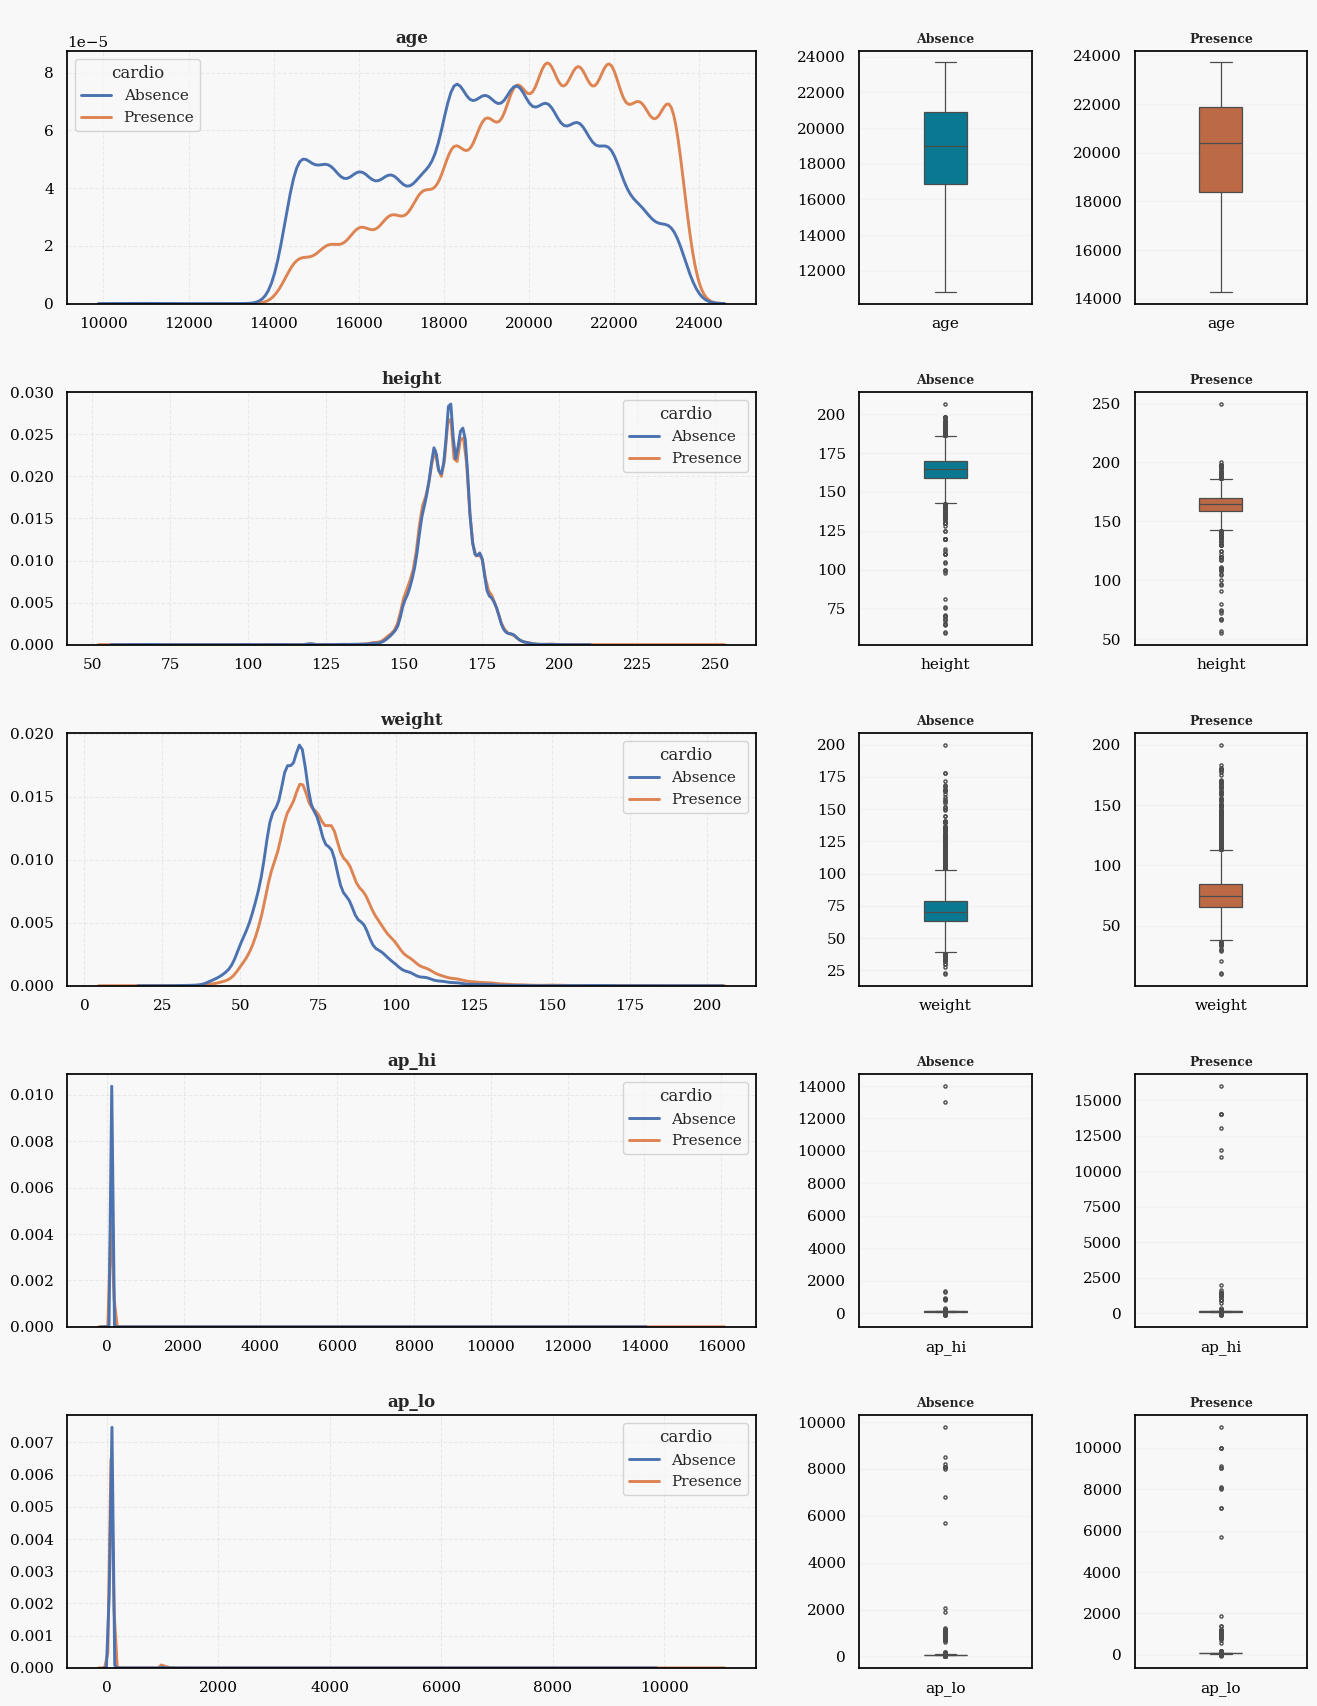

In [1419]:
def hb_plot(_df, _var):
    fig, axes = plt.subplots(len(_var), 3 ,figsize = (16, len(_var) * 4.2), gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20]})
    
    for i, col in enumerate(_var):
        ax = axes[i, 0]
        sns.kdeplot(data = _df[[col, 'cardio']], x = col, ax = ax, hue=_df['cardio'], linewidth = 2.1)
        # sns.histplot(data = _df[[col, 'cardio']], x = col, ax = ax, hue=_df['cardio'], kde=True, linewidth = 2.1)
        ax.set_title(f"\n{col}",fontsize = 12, fontweight= 'bold')
        ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75)
        ax.set(xlabel = '', ylabel = '')
        
        ax = axes[i, 1]
        sns.boxplot(data = _df.loc[_df.cardio == 'Absence', [col]], width = 0.25, fliersize= 2.25, saturation = 0.90, linewidth = 0.90, color = '#037d97', ax = ax)
        ax.set(xlabel = '', ylabel = '')
        ax.set_title(f"Absence", fontsize = 9, fontweight= 'bold')
        
        ax = axes[i, 2]
        sns.boxplot(data = _df.loc[_df.cardio == 'Presence', [col]], width = 0.25, fliersize= 2.25, saturation = 0.6, linewidth = 0.90, color = '#E4591E', ax = ax)
        ax.set_title(f"Presence",fontsize = 9, fontweight= 'bold')
        ax.set(xlabel = '', ylabel = '')

hb_plot(df, num_var)

plt.tight_layout()
plt.show()

<font face='consolas' size=3 color=#f8000b>3. Data Cleaning</font>

In [1420]:
df.isnull().values.any()  # have no null value    

False

In [1421]:
# common sense
print(len(df[df['ap_lo'] < 0]))  # 1
print(len(df[df['ap_hi'] < 0]))  # 6
print(len(df[df['ap_hi'] < df['ap_lo']]))  # 1234
print(len(df[df['ap_lo'] > 300]))  # the indication of normal sphygmomanometer
print(len(df[df['ap_hi'] > 300]))

df.drop(df[(df.ap_lo < 0) | (df.ap_hi < 0) | (df.ap_lo > df.ap_hi) | (df.ap_lo > 300) | (df.ap_hi > 300)].index,inplace=True)

df.shape

1
7
1234
953
40


(68725, 12)

In [1422]:
# Height & Weight & Blood Pressure
def outliers_remove_simple(_df, _low, _high):
    df.drop(df[((df['height'] > df['height'].quantile(_high)) | (df['height'] < df['height'].quantile(_low))) |
               ((df['weight'] > df['weight'].quantile(_high)) | (df['weight'] < df['weight'].quantile(_low))) |
               ((df['ap_lo'] > df['ap_lo'].quantile(_high)) | (df['ap_lo'] < df['ap_lo'].quantile(_low))) |
               ((df['ap_hi'] > df['ap_hi'].quantile(_high)) | (df['ap_hi'] < df['ap_hi'].quantile(_low)))].index, inplace=True)

outliers_remove_simple(df, 0.01, 0.99)

df_1 = df.reset_index(drop=True)
df_1.shape

(65341, 12)

In [1423]:
df_1.describe().T

,count,mean,std,min,25%,50%,75%,max
age,65341.0,19465.685619,2464.964317,10798.0,17663.0,19702.0,21323.0,23713.0
height,65341.0,164.469782,7.294718,147.0,159.0,165.0,170.0,184.0
weight,65341.0,73.724485,12.844731,48.0,65.0,72.0,81.0,117.0
ap_hi,65341.0,126.116849,15.525632,90.0,120.0,120.0,140.0,180.0
ap_lo,65341.0,81.017692,8.694115,60.0,80.0,80.0,90.0,100.0


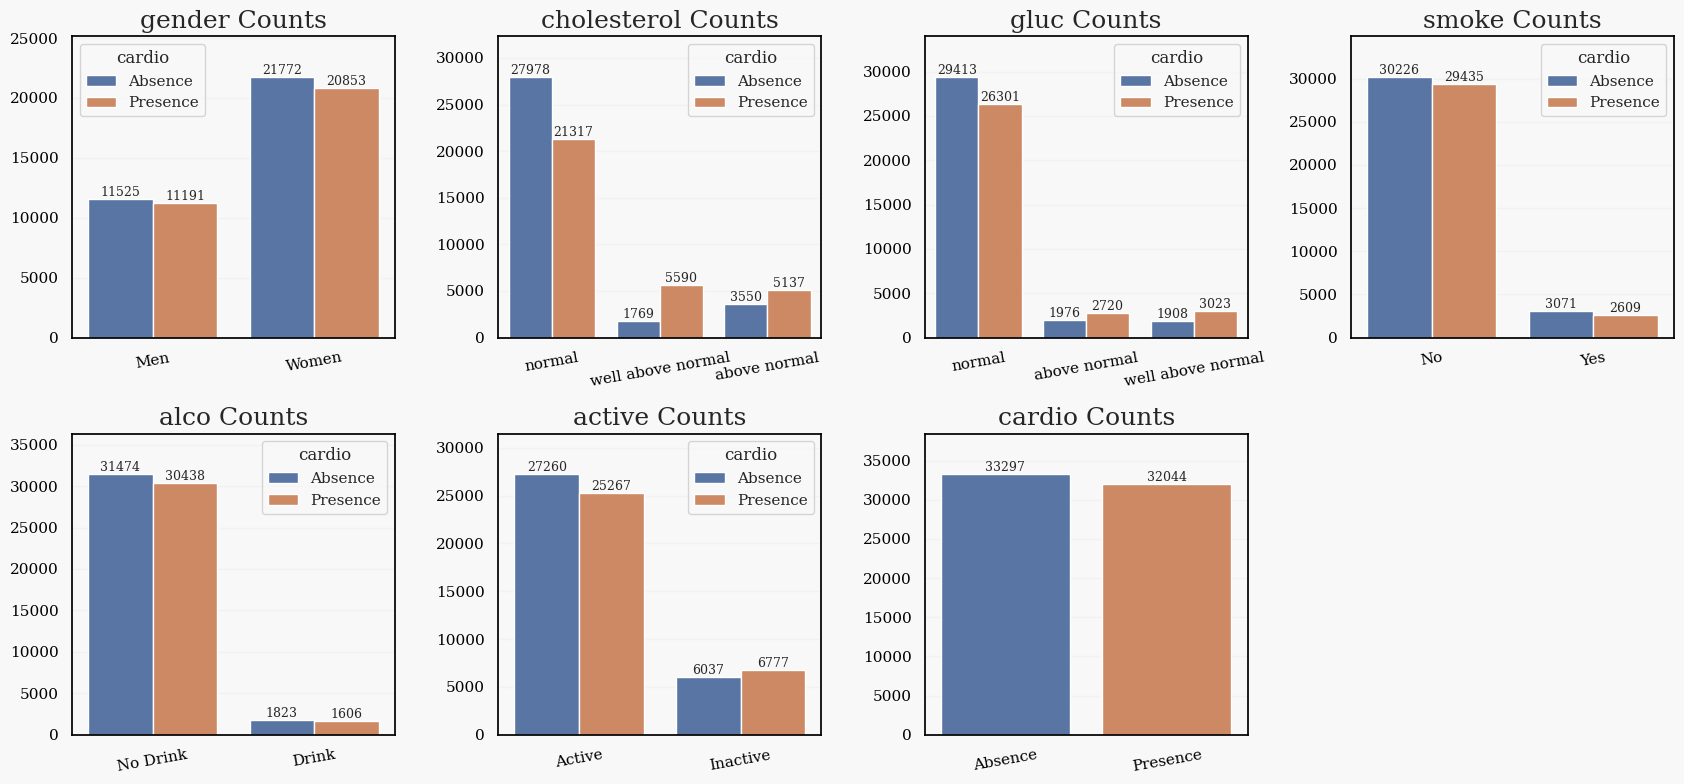

In [1424]:
plot_count(df_1, cat_var, 4, 'cardio')

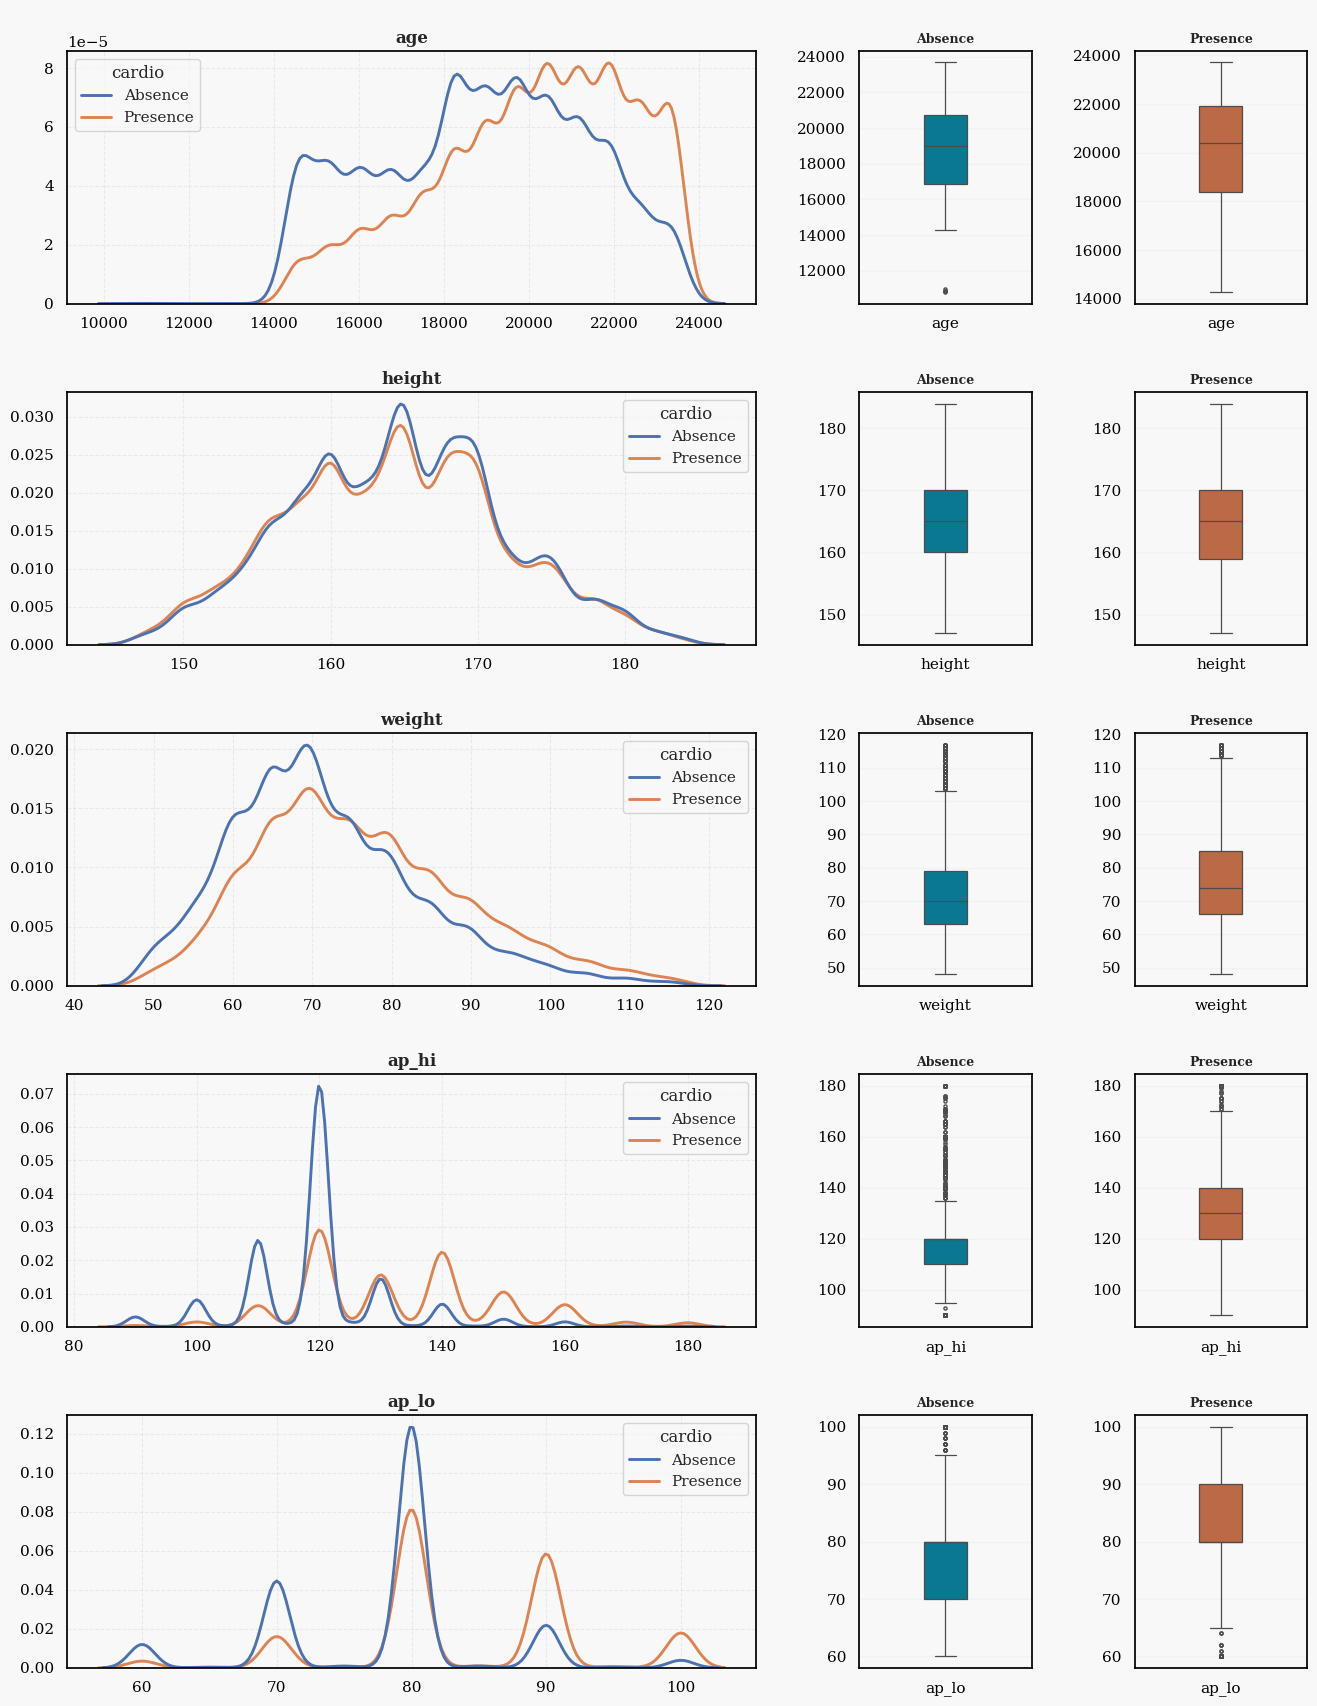

In [1425]:
hb_plot(df_1, num_var)

plt.tight_layout()
plt.show()

<font face='consolas' size=3 color=#f8000b>4. Preprocessing</font>

In [1426]:
df_1['age_year'] = (df_1['age'] / 365).astype(int)  # age_day to age_year
df_1['bmi'] = 10000 * df_1['weight'] / np.power(df_1['height'], 2)  # Calculate BMI
df_1['pp'] = df_1['ap_hi'] - df_1['ap_lo']


pressure_level = lambda x: 'Normal' if ((x['ap_lo'] < 80) and (x['ap_hi'] <120)) else\
                            'Elevated' if ((x['ap_lo'] < 80) and (120 <= x['ap_hi'] < 130)) else\
                            'Hypertension State 1' if ((80 <= x['ap_lo'] < 90) or (130 <= x['ap_hi'] < 140)) else\
                            'Hypertension State 2' if ((90 <= x['ap_lo'] <= 120) or (140 <= x['ap_hi'] <= 180)) else\
                            'Crisis'

df_1['p_l'] = df_1[['ap_hi', 'ap_lo']].apply(pressure_level, axis = 1)

In [1427]:
df_1.describe().T

,count,mean,std,min,25%,50%,75%,max
age,65341.0,19465.685619,2464.964317,10798.000000,17663.000000,19702.000000,21323.000000,23713.000000
height,65341.0,164.469782,7.294718,147.000000,159.000000,165.000000,170.000000,184.000000
weight,65341.0,73.724485,12.844731,48.000000,65.000000,72.000000,81.000000,117.000000
ap_hi,65341.0,126.116849,15.525632,90.000000,120.000000,120.000000,140.000000,180.000000
ap_lo,65341.0,81.017692,8.694115,60.000000,80.000000,80.000000,90.000000,100.000000
age_year,65341.0,52.831851,6.760541,29.000000,48.000000,53.000000,58.000000,64.000000
bmi,65341.0,27.297800,4.760220,15.094795,23.875115,26.297578,30.043262,51.313539
pp,65341.0,45.099157,11.068405,0.000000,40.000000,40.000000,50.000000,120.000000


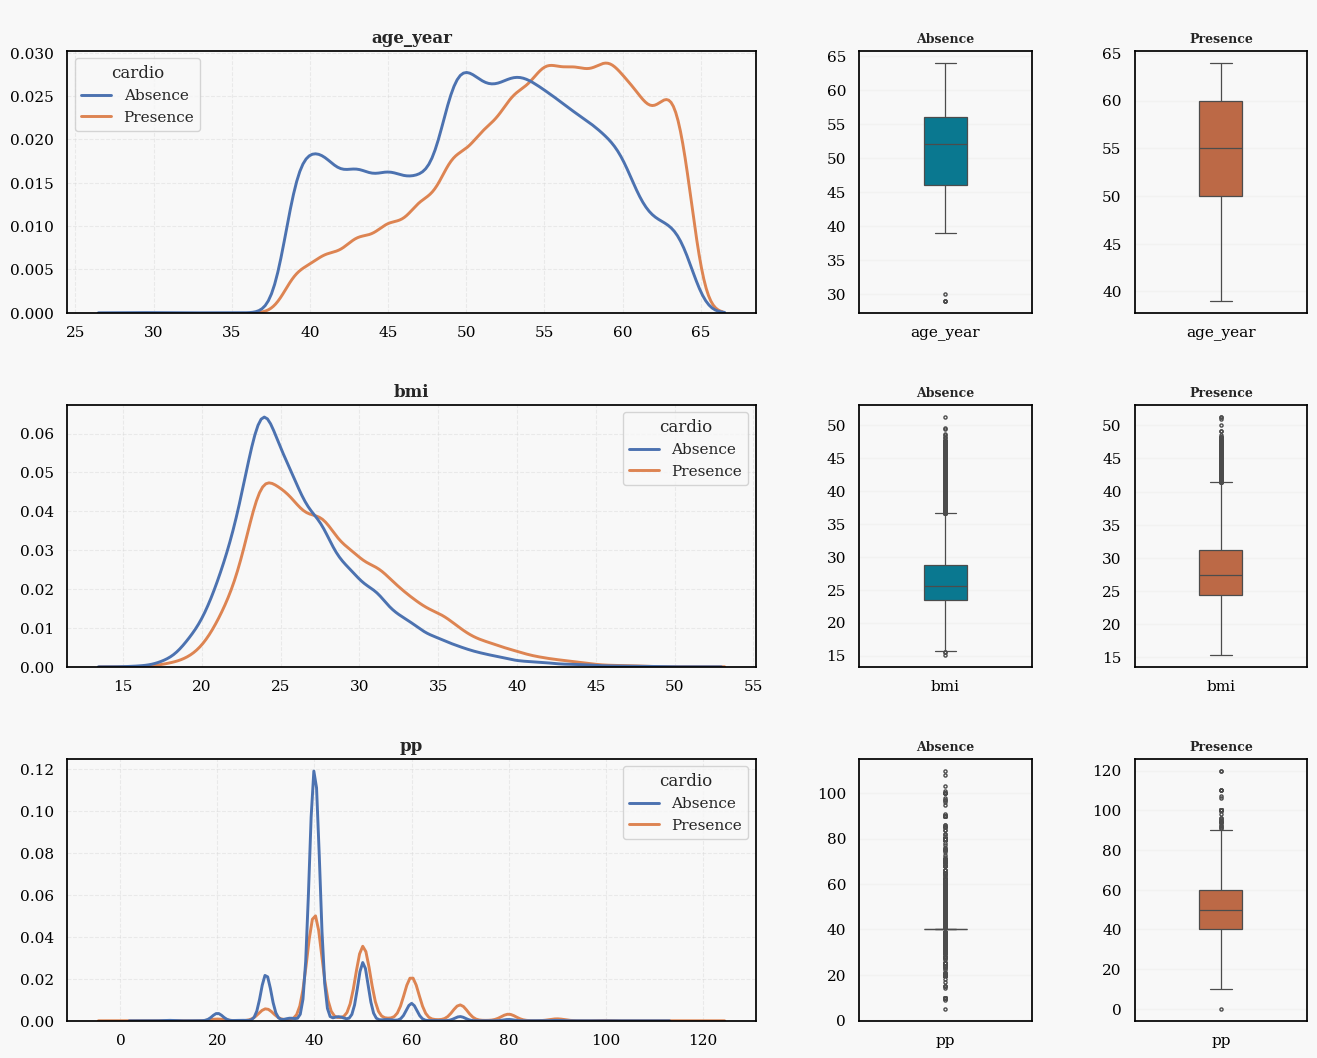

In [1428]:
hb_plot(df_1, ['age_year', 'bmi', 'pp'])

<font face='consolas' size=3 color=#f8000b>5. Mann-Whitney U-test</font>

In [1429]:
# Mann-Whitney U-test
lc = lambda y : 1 if y == 'normal' else 2 if y == 'above normal' else 3

cholesterol_health = df_1[df_1['cardio'] == 'Absence'].cholesterol.apply(lc)  # Cholesterol data of healthy people
cholesterol_patient = df_1[df_1['cardio'] == 'Presence'].cholesterol.apply(lc)  # Cholesterol data of patients

stats.mannwhitneyu(cholesterol_patient, cholesterol_health, alternative='greater')  # Significance Level = 0.05

MannwhitneyuResult(statistic=632230549.0, pvalue=0.0)

<font face='consolas' size=3 color=#f8000b>6. ANOVA</font>

Text(0.5, 1.0, 'BMI Distribution of Patient (Transformed)')

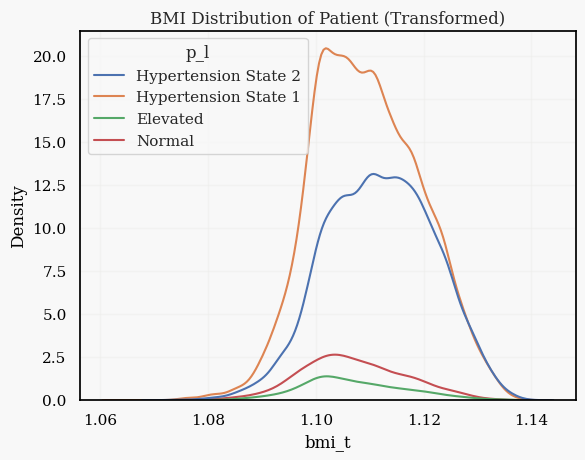

In [1430]:
# For patients
# Step 1 Box-Cox Normal Transform

df_p = df_1[df_1['cardio'] == 'Presence']  # Select the data of patients

# Empirical rule
# print(df_p['bmi'].median() / df_p['bmi'].mean())
# print(df_p['bmi'].mean())
# print(df_p['bmi'].std())

# k = sns.kdeplot(data = df_p, x = df_p['bmi'], hue='p_l')
# k.set_title('BMI Distribution of Patient')

transformed_data, best_lambda = boxcox(df_p['bmi'])  # BOX-COX Normal Transform

df_p['bmi_t'] = transformed_data
kt = sns.kdeplot(data = df_p, x = df_p['bmi_t'], hue='p_l')
kt.set_title('BMI Distribution of Patient (Transformed)')

In [1431]:
# Step 2 Homogeneity of variance test
groups = []

for n, g in df_p.groupby('p_l')['bmi_t']:
    groups.append(g.values)

levene(*groups, center='mean')  # *-ungrouped

LeveneResult(statistic=3.5956414752824237, pvalue=0.01294547335320991)

In [1432]:
# Step 3 Implement ANOVA
model = ols('bmi_t ~ p_l', data = df_p).fit()
anova_result = sm.stats.anova_lm(model, typ=1)
anova_result

,df,sum_sq,mean_sq,F,PR(>F)
p_l,3.0,0.074279,0.024760,252.716721,4.214094e-162
Residual,32040.0,3.139078,0.000098,NaN,NaN


group1,group2,meandiff,p-adj,lower,upper,reject
Elevated,Hypertension State 1,0.0025,0.0,0.0016,0.0033,True
Elevated,Hypertension State 2,0.0049,0.0,0.004,0.0057,True
Elevated,Normal,-0.0001,0.9895,-0.0011,0.0009,False
Hypertension State 1,Hypertension State 2,0.0024,0.0,0.0021,0.0027,True
Hypertension State 1,Normal,-0.0026,0.0,-0.0032,-0.002,True
Hypertension State 2,Normal,-0.005,0.0,-0.0056,-0.0044,True


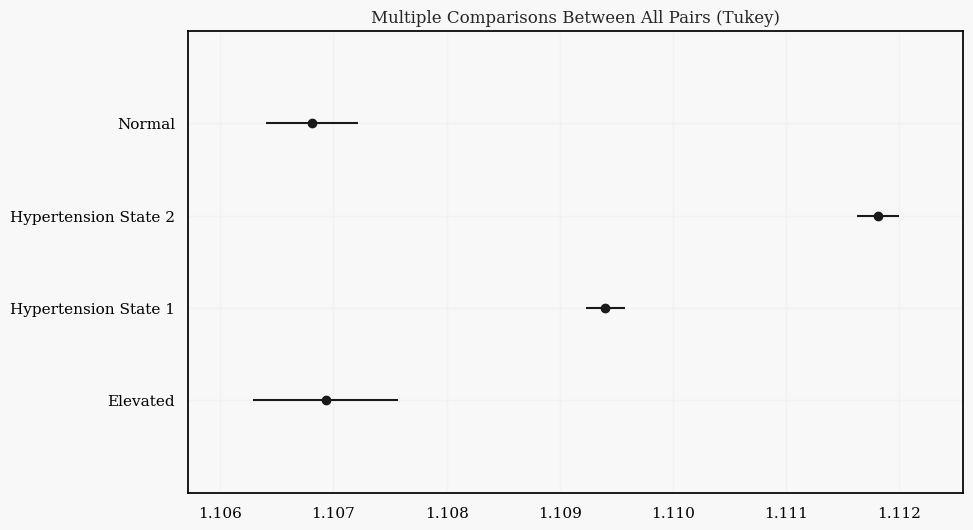

In [1433]:
# Step 4 Multiple Comparisons
tukey = pairwise_tukeyhsd(df_p['bmi_t'], df_p['p_l'], alpha=0.05)
tukey.plot_simultaneous()

tukey.summary()

<font face='consolas' size=3 color=#f8000b>7. Random Classification</font>

In [ ]:
# Waiting

Data Source: https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset